In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne
import os
from tqdm import tqdm

from scipy.stats import kurtosis, skew

from typing import List, Tuple

from mne.io import read_raw_eeglab

In [6]:
# Chunk data into 1 second epochs with 20% overlap
def chunk_data(raw: mne.io.Raw, epoch_length=1, overlap=0.2) -> List[mne.io.Raw]:
    total_recording_time = raw.times[-1]  # in seconds
    overlap_length = epoch_length * overlap
    start = 0
    epochs = []
    while start + epoch_length < total_recording_time:
        epochs.append(raw.copy().crop(tmin=start, tmax=start + epoch_length))
        start += epoch_length - overlap_length
    return epochs


# calculate the mean of each channel over time
def calculate_mean(epochs: List[mne.io.Raw]) -> np.ndarray:
    means = []
    for epoch in epochs:
        try:
            means.append(epoch.get_data().mean(axis=1))
        except:
            print("Error")
            print(epoch.get_data().shape)
            break

    return np.array(means)


# calculate the Variance and Standard Deviation of each channel over time
def calculate_variance(epochs: List[mne.io.Raw]) -> np.ndarray:
    variances = []
    for epoch in epochs:
        variances.append(epoch.get_data().var(axis=1))
    return np.array(variances)


def calculate_std(epochs: List[mne.io.Raw]) -> np.ndarray:
    stds = []
    for epoch in epochs:
        stds.append(epoch.get_data().std(axis=1))
    return np.array(stds)


# calculate the Peak-to-Peak Amplitude of each channel over time
def calculate_peak_to_peak(epochs: List[mne.io.Raw]) -> np.ndarray:
    peak_to_peaks = []
    for epoch in epochs:
        peak_to_peaks.append(epoch.get_data().ptp(axis=1))
    return np.array(peak_to_peaks)


# calculate the Root Mean Square (RMS) of each channel over time
def calculate_rms(epochs: List[mne.io.Raw]) -> np.ndarray:
    rms = []
    for epoch in epochs:
        rms.append(np.sqrt(np.mean(epoch.get_data() ** 2, axis=1)))
    return np.array(rms)


# calculate the Skewness and Kurtosis of each channel over time
def calculate_skewness(epochs: List[mne.io.Raw]) -> np.ndarray:
    skewness_value = []
    for epoch in epochs:
        skewness_value.append(skew(epoch.get_data(), axis=1))
    return np.array(skewness_value)


def calculate_kurtosis(epochs: List[mne.io.Raw]) -> np.ndarray:
    kurtosis_value = []
    for epoch in epochs:
        kurtosis_value.append(kurtosis(epoch.get_data(), axis=1))
    return np.array(kurtosis_value)


def calculate_features(
    epochs: List[mne.io.Raw], is_channel_wise: bool = True
) -> pd.DataFrame:
    mean = calculate_mean(epochs)
    variance = calculate_variance(epochs)
    std = calculate_std(epochs)
    peak_to_peak = calculate_peak_to_peak(epochs)
    rms = calculate_rms(epochs)
    skewness = calculate_skewness(epochs)
    kurtosis = calculate_kurtosis(epochs)

    if is_channel_wise:
        axis = 0
    else:
        axis = 1

    return pd.DataFrame(
        {
            "mean": mean.mean(axis=axis),
            "variance": variance.mean(axis=axis),
            "std": std.mean(axis=axis),
            "peak_to_peak": peak_to_peak.mean(axis=axis),
            "rms": rms.mean(axis=axis),
            "skewness": skewness.mean(axis=axis),
            "kurtosis": kurtosis.mean(axis=axis),
        }
    )

In [7]:
input_fnames = {
    "pre": [
        "/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.set",
        "/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.set",
        "/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.set",
    ],
    "break": [
        "/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_RELAX.set",
        "/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_RELAX.set",
    ],
    "post": [
        "/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.set",
        "/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.set",
        # "/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_RELAX.set",
        "/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.set",
    ],
}

In [46]:
epoch_length = 5
overlap = 0.3
eog = ()

pre_epochs = []
for input_fname in input_fnames["pre"]:
    pre_raws = read_raw_eeglab(
        input_fname=input_fname, eog=eog, preload=True, montage_units="mm", verbose=True
    )
    pre_epochs.extend(chunk_data(pre_raws, epoch_length=epoch_length, overlap=overlap))

post_epochs = []
for input_fname in input_fnames["post"]:
    post_raws = read_raw_eeglab(
        input_fname=input_fname, eog=eog, preload=True, montage_units="mm", verbose=True
    )
    post_epochs.extend(
        chunk_data(post_raws, epoch_length=epoch_length, overlap=overlap)
    )

len(pre_epochs), len(post_epochs)

Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_31422/4094743639.py:7: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_31422/4094743639.py:7: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_31422/4094743639.py:7: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_31422/4094743639.py:7: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_31422/4094743639.py:7: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_31422/4094743639.py:7: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_31422/4094743639.py:7: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_31422/4094743639.py:7: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  pre_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_31422/4094743639.py:7: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  pre_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_31422/4094743639.py:14: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_31422/4094743639.py:14: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_31422/4094743639.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_31422/4094743639.py:14: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_31422/4094743639.py:14: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_31422/4094743639.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_31422/4094743639.py:14: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_31422/4094743639.py:14: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  post_raws = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_31422/4094743639.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  post_raws = read_raw_eeglab(


(98, 98)

In [47]:
pre_features = calculate_features(pre_epochs, is_channel_wise=False)  # 1 row per epoch
post_features = calculate_features(
    post_epochs, is_channel_wise=False
)  # 1 row per epoch
pre_features["label"] = 0  # "pre"
post_features["label"] = 1  # "post"

features = pd.concat([pre_features, post_features])

In [48]:
features

,mean,variance,std,peak_to_peak,rms,skewness,kurtosis,label
0,3.458918e-09,4.647070e-11,0.000007,0.000040,0.000007,-0.065265,0.076149,0
1,-7.053781e-09,5.772735e-11,0.000007,0.000045,0.000007,-0.031451,0.200601,0
2,3.238938e-09,4.126980e-11,0.000006,0.000040,0.000006,-0.013794,0.300377,0
3,4.539961e-09,4.750676e-11,0.000007,0.000039,0.000007,-0.037914,-0.095478,0
4,2.768251e-09,5.187479e-11,0.000007,0.000045,0.000007,-0.060547,0.560251,0
...,...,...,...,...,...,...,...,...
93,4.883767e-09,8.152741e-11,0.000009,0.000052,0.000009,-0.004758,-0.058619,1
94,-5.561402e-09,6.497994e-11,0.000008,0.000050,0.000008,-0.029181,0.243654,1
95,2.360824e-09,4.935580e-11,0.000007,0.000044,0.000007,-0.003912,0.194677,1
96,-1.393233e-09,3.491352e-11,0.000006,0.000035,0.000006,0.006357,0.142415,1


# Performing supervise learning to see how can these signals be differenciate from each other?

- Zero, this is average of whole channels
- First using the whole features
- Second using every signle features
- Using 10 split of data
- First standarize our features
- Second use several machine learning algorithms to tackle the problem
- Third trying to find best parameter for each training

In [49]:
import wandb
from wandb.sklearn import plot_precision_recall, plot_feature_importances
from wandb.sklearn import plot_class_proportions, plot_learning_curve, plot_roc

import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier


# Define the models and parameters for grid search
models_and_parameters = {
    "SVM": (
        SVC(),
        {"svm__C": [1e-3, 1e-2, 0.1, 1, 10, 1e3], "svm__kernel": ["linear", "rbf"]},
    ),
    "Decision_Tree": (
        DecisionTreeClassifier(),
        {
            "decision_tree__max_depth": [3, 5, 10],
            "decision_tree__min_samples_split": [2, 5, 10],
        },
    ),
    "LDA": (LinearDiscriminantAnalysis(), {"lda__solver": ["svd", "lsqr"]}),
    "MLP": (
        MLPClassifier(max_iter=1000),
        {
            "mlp__hidden_layer_sizes": [
                (50,),
                (100,),
                (
                    100,
                    10,
                ),
            ],
            "mlp__activation": ["tanh", "relu"],
            "mlp__alpha": [0.0001, 0.001, 0.01],
        },
    ),
    "RandomForestClassifier": (
        RandomForestClassifier(),
        {
            "randomforestclassifier__n_estimators": [40, 50, 60],
            "randomforestclassifier__max_features": ["sqrt", "log2"],
        },
    ),
    "XGBClassifier": (
        XGBClassifier(),
        {
            "xgbclassifier__n_estimators": [50, 100, 200],
            "xgbclassifier__learning_rate": [0.01, 0.1, 0.2],
            "xgbclassifier__subsample": [0.7, 0.8, 0.9],
        },
    ),
}

# Define 5-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# List to hold the best models for each classifier
best_models = []

results = {
    "experiment_name": [],
    "model_name": [],
    "best_params": [],
    "best_score": [],
    "test_score": [],
    "grid_search_std_test_score": [],
    "grid_search_mean_test_score": [],
}


for experiment_name in [
    "all_features",
    "mean",
    "variance",
    "std",
    "peak_to_peak",
    "rms",
    "skewness",
    "kurtosis",
]:
    # Create a synthetic dataset

    if experiment_name == "all_features":
        X, y = features.drop("label", axis=1).to_numpy(), features["label"].to_numpy()
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

    else:
        X, y = (
            features[experiment_name].to_numpy().reshape(-1, 1),
            features["label"].to_numpy(),
        )
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

    # Loop through models and parameters, and perform grid search
    for name, (model, params) in tqdm(models_and_parameters.items()):

        pipeline = Pipeline(
            [
                ("scaler", StandardScaler()),  # Data standardization
                (name.lower(), model),  # Model
            ]
        )
        clf = GridSearchCV(pipeline, params, cv=kfold, scoring="accuracy", n_jobs=-1)
        clf.fit(X_train, y_train)
        print(f"Best parameters for {name}: {clf.best_params_}")
        print(f"Best cross-validation score for {name}: {clf.best_score_:.3f}")
        best_models.append(clf.best_estimator_)

        results["model_name"].append(name)
        results["best_params"].append(clf.best_params_)
        results["best_score"].append(clf.best_score_)
        results["test_score"].append(clf.best_estimator_.score(X_test, y_test))
        results["experiment_name"].append(experiment_name)
        results["grid_search_std_test_score"].append(
            np.mean(clf.cv_results_["std_test_score"])
        )
        results["grid_search_mean_test_score"].append(
            np.mean(clf.cv_results_["mean_test_score"])
        )


results = pd.DataFrame(results)
results

 17%|█▋        | 1/6 [00:00<00:01,  3.74it/s]

Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.609
Best parameters for Decision_Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.538
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.615


/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/

Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.596


 83%|████████▎ | 5/6 [00:09<00:01,  1.83s/it]

Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.602


100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.616


 17%|█▋        | 1/6 [00:00<00:00,  9.22it/s]

Best parameters for SVM: {'svm__C': 0.1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.610
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.571
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.597


 67%|██████▋   | 4/6 [00:00<00:00,  4.67it/s]

Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.603


 83%|████████▎ | 5/6 [00:01<00:00,  3.76it/s]

Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.519


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.640


 17%|█▋        | 1/6 [00:00<00:00,  9.20it/s]

Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score for SVM: 0.564
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.506
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.551


 67%|██████▋   | 4/6 [00:00<00:00,  5.05it/s]

Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.583


 83%|████████▎ | 5/6 [00:01<00:00,  4.05it/s]

Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.455


100%|██████████| 6/6 [00:01<00:00,  3.56it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.525


 17%|█▋        | 1/6 [00:00<00:00,  8.79it/s]

Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.551
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 5}
Best cross-validation score for Decision_Tree: 0.545
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.538


 67%|██████▋   | 4/6 [00:00<00:00,  5.43it/s]

Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.576


 83%|████████▎ | 5/6 [00:01<00:00,  4.16it/s]

Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.455


100%|██████████| 6/6 [00:01<00:00,  3.66it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.558


 17%|█▋        | 1/6 [00:00<00:00,  8.53it/s]

Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.551


 33%|███▎      | 2/6 [00:00<00:00,  6.70it/s]

Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.506
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.493


 67%|██████▋   | 4/6 [00:00<00:00,  3.96it/s]

Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.564


 83%|████████▎ | 5/6 [00:01<00:00,  3.53it/s]

Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.512


100%|██████████| 6/6 [00:01<00:00,  3.24it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Best cross-validation score for XGBClassifier: 0.512


 17%|█▋        | 1/6 [00:00<00:00,  9.31it/s]

Best parameters for SVM: {'svm__C': 1000.0, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.551
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.519


 50%|█████     | 3/6 [00:00<00:00, 15.03it/s]

Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.538
Best parameters for MLP: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.576


 83%|████████▎ | 5/6 [00:01<00:00,  3.60it/s]

Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 40}
Best cross-validation score for RandomForestClassifier: 0.455


100%|██████████| 6/6 [00:01<00:00,  3.55it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.564


 17%|█▋        | 1/6 [00:00<00:00,  7.86it/s]

Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.564
Best parameters for Decision_Tree: {'decision_tree__max_depth': 5, 'decision_tree__min_samples_split': 10}
Best cross-validation score for Decision_Tree: 0.576
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.461


 67%|██████▋   | 4/6 [00:00<00:00,  4.18it/s]

Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best cross-validation score for MLP: 0.544


 83%|████████▎ | 5/6 [00:01<00:00,  3.54it/s]

Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.564


100%|██████████| 6/6 [00:01<00:00,  3.18it/s]


Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.545


 17%|█▋        | 1/6 [00:00<00:00,  8.29it/s]

Best parameters for SVM: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score for SVM: 0.577
Best parameters for Decision_Tree: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}
Best cross-validation score for Decision_Tree: 0.526
Best parameters for LDA: {'lda__solver': 'svd'}
Best cross-validation score for LDA: 0.596


 67%|██████▋   | 4/6 [00:00<00:00,  4.79it/s]

Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 10)}
Best cross-validation score for MLP: 0.602


 83%|████████▎ | 5/6 [00:01<00:00,  3.09it/s]

Best parameters for RandomForestClassifier: {'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for RandomForestClassifier: 0.443


100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

Best parameters for XGBClassifier: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__subsample': 0.7}
Best cross-validation score for XGBClassifier: 0.527


,experiment_name,model_name,best_params,best_score,test_score,grid_search_std_test_score,grid_search_mean_test_score
0,all_features,SVM,"{'svm__C': 1, 'svm__kernel': 'linear'}",0.609073,0.575,0.056523,0.543179
1,all_features,Decision_Tree,"{'decision_tree__max_depth': 10, 'decision_tre...",0.537903,0.500,0.065084,0.489561
2,all_features,LDA,{'lda__solver': 'svd'},0.615323,0.575,0.054195,0.615323
3,all_features,MLP,"{'mlp__activation': 'tanh', 'mlp__alpha': 0.00...",0.596371,0.600,0.081435,0.563273
4,all_features,RandomForestClassifier,{'randomforestclassifier__max_features': 'sqrt...,0.602218,0.600,0.043183,0.567238
5,all_features,XGBClassifier,"{'xgbclassifier__learning_rate': 0.1, 'xgbclas...",0.615524,0.550,0.060055,0.584364
6,mean,SVM,"{'svm__C': 0.1, 'svm__kernel': 'linear'}",0.609879,0.525,0.063260,0.526042
7,mean,Decision_Tree,"{'decision_tree__max_depth': 5, 'decision_tree...",0.570766,0.525,0.095617,0.524798
8,mean,LDA,{'lda__solver': 'svd'},0.596976,0.525,0.100727,0.596976
9,mean,MLP,"{'mlp__activation': 'tanh', 'mlp__alpha': 0.00...",0.603427,0.525,0.083950,0.571573


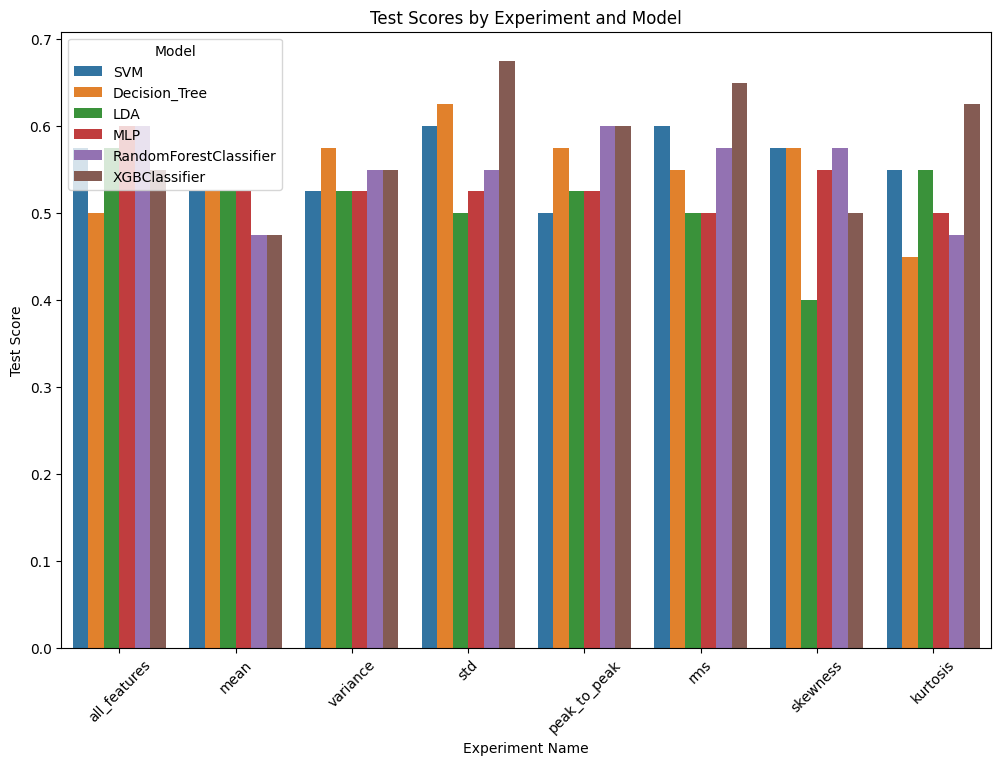

In [50]:
import seaborn as sns

# Create a figure and axis object
plt.figure(figsize=(12, 8))

# Plotting using seaborn to automatically handle the multiple categories
sns.barplot(
    data=results,
    x="experiment_name",
    y="test_score",
    hue="model_name",
    errorbar="sd",
)

# Adding titles and labels
plt.title("Test Scores by Experiment and Model")
plt.xlabel("Experiment Name")
plt.ylabel("Test Score")

# Improving layout
plt.xticks(rotation=45)  # Rotates the labels on the x-axis for better readability
plt.legend(title="Model")

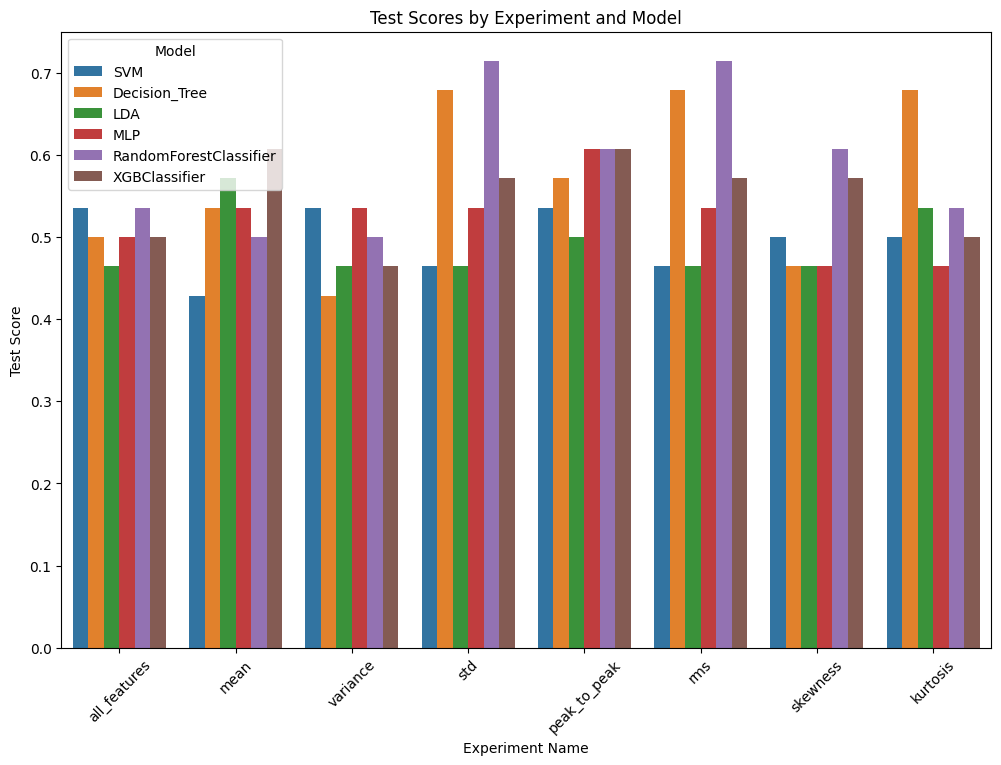

In [38]:
import seaborn as sns

# Create a figure and axis object
plt.figure(figsize=(12, 8))

# Plotting using seaborn to automatically handle the multiple categories
sns.barplot(
    data=results,
    x="experiment_name",
    y="test_score",
    hue="model_name",
    errorbar="sd",
)

# Adding titles and labels
plt.title("Test Scores by Experiment and Model")
plt.xlabel("Experiment Name")
plt.ylabel("Test Score")

# Improving layout
plt.xticks(rotation=45)  # Rotates the labels on the x-axis for better readability
plt.legend(title="Model")

In [14]:
# This script needs these libraries to be installed:
#   numpy, sklearn

import wandb
from wandb.sklearn import plot_precision_recall, plot_feature_importances
from wandb.sklearn import plot_class_proportions, plot_learning_curve, plot_roc

import numpy as np
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


# load and process data
wbcd = datasets.load_breast_cancer()
feature_names = wbcd.feature_names
labels = wbcd.target_names

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    wbcd.data, wbcd.target, test_size=test_size
)

# train model
model = RandomForestClassifier()
model.fit(X_train, y_train)
model_params = model.get_params()

# get predictions
y_pred = model.predict(X_test)
y_probas = model.predict_proba(X_test)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# start a new wandb run and add your model hyperparameters
wandb.init(project="my-awesome-project", config=model_params)

# Add additional configs to wandb
wandb.config.update(
    {"test_size": test_size, "train_len": len(X_train), "test_len": len(X_test)}
)

# log additional visualisations to wandb
plot_class_proportions(y_train, y_test, labels)
plot_learning_curve(model, X_train, y_train)
plot_roc(y_test, y_probas, labels)
plot_precision_recall(y_test, y_probas, labels)
plot_feature_importances(model)

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
wandb: Currently logged in as: soroushziaee1 (vielight). Use `wandb login --relogin` to force relogin
